# Assignment 1 Starter Notebook (TensorFlow/Keras)
## Foundations of Neural Networks and Backpropagation (Weeks 2–3)

**Lectures covered:** Week 2–3 (Supervised learning, loss functions, perceptron-style model, MLPs, backpropagation concept & implementation)

**Dataset:** California Housing Prices (1990 U.S. Census) via scikit-learn

> This notebook is a starter template. Complete all **TODO** sections and ensure results are reproducible (set seeds).


In [2]:
# === cuDNN mismatch issues (TensorFlow in my conda env was compiled expecting cuDNN 8.9.4 but my system actually has cuDNN 8.0.5

import os

# Disable GPU and XLA to avoid cuDNN / JIT issues
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

import tensorflow as tf
tf.config.optimizer.set_jit(False)

print("Num GPUs Available:", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available: 0


In [17]:
# === Imports ===
import random
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
# === Reproducibility ===
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.15.1


## Q1. Load dataset (required access method)

### Load California Housing Dataset

- We load the California Housing dataset using `scikit-learn` with `as_frame=True` to obtain pandas objects.  
- `X` contains the feature matrix (20,640 samples × 8 features), and `y` contains the target variable representing median house value.


In [5]:
# Required access method:
data = fetch_california_housing(as_frame=True)

X = data.data  # pandas DataFrame of shape (20640, 8)
y = data.target  # pandas Series

print("X shape:", X.shape)
print("y shape:", y.shape)
X.head()
# y.head()

X shape: (20640, 8)
y shape: (20640,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## ✅ Student Instructions (Start Here)

Your work begins in the next **code cells (Q2–Q10)** and continues by answering questions in the **Markdown cells (Q11–Q14)**. These correspond to the questions listed in the assignment description on Canvas.. Complete each cell by following the instructions provided in the **preceding Markdown cells**.

Please:
- **Read the instructions carefully** before coding.
- Take your time to **understand each question** and implement the required steps.
- Each code cell includes **partial starter code**—your task is to **fill in the missing parts** and ensure the cell runs correctly.

If you need clarification at any point, please contact the **teaching staff (instructor/TA)** for support.


## Q2. Train/Validation/Test split

### 🔹 Dataset Splitting (Train / Validation / Test)

#### What you need to do:
1. **Split the dataset into three parts** using a **70/15/15 ratio**:
   - 70% for training
   - 15% for validation
   - 15% for testing

2. **Perform the split in two steps**:
   - First, split the data into **training (70%)** and a temporary set (30%)
   - Then, split the temporary set evenly into **validation** and **test** sets

3. **Ensure reproducibility**
   - Use the provided random seed for all splits

4. **Verify the result**
   - Print and confirm the shapes of the training, validation, and test sets
   - Check that the splits approximately match the 70/15/15 ratio


In [6]:
# TODO: Use a 70/15/15 split (train/val/test).
# Hint: split once into train+temp, then temp into val/test.

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state= SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size= 0.50,
    random_state= SEED
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (14448, 8) Val: (3096, 8) Test: (3096, 8)


## Q3. Preprocessing (standardize numeric features)

### 🔹 Feature Standardization & Target Preparation

In this step, you will prepare the dataset for training a neural network.

#### What you need to do:
1. **Standardize the input features** using **only the training set statistics**.
   - Fit the scaler on `X_train`
   - Apply the same transformation to `X_val` and `X_test`
   - Do **not** refit the scaler on validation or test data

2. **Convert target variables to `float32`**
   - This ensures compatibility with TensorFlow models
   - Apply the conversion consistently to training, validation, and test targets

3. **Verify data types**
   - Print the data types of the standardized features and targets
   - Confirm that inputs are numeric and targets are `float32`

📌 **Why this matters**:  
Using training-only statistics prevents data leakage, and ensuring consistent data types avoids runtime errors during model training.

When completed, you should have:
- Standardized feature matrices: `X_train_s`, `X_val_s`, `X_test_s`
- Float32 target arrays: `y_train_f`, `y_val_f`, `y_test_f`


In [7]:
# Standardize features using statistics from the training set only.

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# Convert targets to float32 for TensorFlow

y_train_f = y_train.to_numpy().astype("float32")
y_val_f   = y_val.to_numpy().astype("float32")
y_test_f  = y_test.to_numpy().astype("float32")


print(X_train_s.dtype, y_train_f.dtype)
print(X_train_s.shape)

float64 float32
(14448, 8)


## Q4. Build models: (A) Single-layer network, (B) MLP

### 🔹 Model Architecture Construction

In this step, you will define and inspect two neural network models for a regression task.

#### What you need to do:
1. **Implement a single-layer model (Perceptron-style)**
   - Create a neural network with **no hidden layers**
   - Use a **single linear output neuron**
   - This model serves as a **baseline** equivalent to linear regression

2. **Implement a Multi-Layer Perceptron (MLP)**
   - Include **at least two hidden layers**
   - Use a nonlinear activation function (e.g., ReLU)
   - End with a **linear output layer** for regression

3. **Initialize both models using the input feature dimension**
   - Determine `input_dim` from the standardized training data
   - Ensure model input shapes match the feature matrix

4. **Inspect the model architectures**
   - Print the model summaries
   - Verify the number of layers, parameters, and output shapes

📌 **Why this matters**:  
Comparing a linear model with a deeper MLP helps you understand how network depth and nonlinearity affect learning capacity and performance.

When completed, you should have:
- A **baseline single-layer model**
- A **deeper MLP model**
- Printed summaries confirming correct architecture


In [8]:
def build_single_layer_model(input_dim: int) -> keras.Model:
    """Perceptron-style: no hidden layers (linear regression)."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(1)  # linear output
    ])
    return model


def build_mlp_model(input_dim: int, hidden_units=(128, 64), activation="relu") -> keras.Model:
    """MLP with at least two hidden layers."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_units[0], activation=activation),
        layers.Dense(hidden_units[1], activation=activation),
        layers.Dense(1)  # linear output for regression
    ])
    return model


input_dim = X_train_s.shape[1]
single_layer = build_single_layer_model(input_dim)
mlp = build_mlp_model(input_dim)

# Model Summary
single_layer.summary()
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 9 (36.00 Byte)
Trainable params: 9 (36.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               1152      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
To

## Q5. Loss functions study (MSE vs MAE)

### 🔹 Model Compilation, Training, and Loss Comparison

In this step, you will compile and train the **same MLP architecture** using **different loss functions**, then compare their learning behavior.

#### What you need to do:
1. **Compile the model**
   - Use **Stochastic Gradient Descent (SGD)** as the optimizer
   - Set an appropriate learning rate
   - Select a regression loss function (`MSE` or `MAE`)
   - Track performance using **RMSE** and **MAE** metrics

2. **Train the model**
   - Train the model using the **training set**
   - Monitor performance on the **validation set**
   - Use the same number of epochs and batch size for fair comparison

3. **Repeat training with different loss functions**
   - Train one model using **Mean Squared Error (MSE)**
   - Train another model using **Mean Absolute Error (MAE)**
   - Keep all other hyperparameters identical

4. **Visualize and compare learning curves**
   - Plot training and validation loss for both models
   - Compare convergence speed and stability across loss functions

📌 **Why this matters**:  
Different loss functions emphasize errors differently. MSE penalizes large errors more strongly, while MAE is more robust to outliers. Comparing them helps you understand how loss choice affects optimization and model behavior.

When completed, you should be able to answer:
- Which loss converges faster?
- Which loss shows more stable validation performance?
- How does the choice of loss affect overfitting or underfitting?


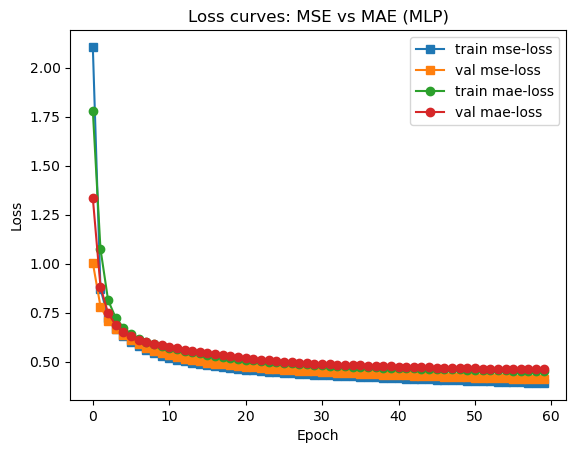

MSE Lowest Val Loss: 0.410072386264801
MAE Lowest Val Loss: 0.46026620268821716


In [9]:
def compile_and_fit(
    model: keras.Model,
    loss_name: str,
    lr: float = 1e-3,
    epochs: int = 60,
    batch_size: int = 64
):
    model = keras.models.clone_model(model)
    model.build((None, X_train_s.shape[1]))

    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=lr),
        loss=loss_name,
        metrics=[
            keras.metrics.RootMeanSquaredError(name="rmse"),
            keras.metrics.MeanAbsoluteError(name="mae")
        ]
    )

    history = model.fit(
        X_train_s, y_train_f,
        validation_data=(X_val_s, y_val_f),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    return model, history


# TODO: Run the same MLP architecture with MSE and MAE
mlp_mse, hist_mse = compile_and_fit(mlp, loss_name="mse", lr=1e-3, epochs=60)
mlp_mae, hist_mae = compile_and_fit(mlp, loss_name="mae", lr=1e-3, epochs=60)

# Plot losses
plt.figure()
plt.plot(hist_mse.history["loss"], label="train mse-loss", marker='s')
plt.plot(hist_mse.history["val_loss"], label="val mse-loss", marker='s')
plt.plot(hist_mae.history["loss"], label="train mae-loss", marker='o')
plt.plot(hist_mae.history["val_loss"], label="val mae-loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curves: MSE vs MAE (MLP)")
plt.show()

print("MSE Lowest Val Loss:", np.min(hist_mse.history["val_loss"]))
print("MAE Lowest Val Loss:", np.min(hist_mae.history["val_loss"]))

## Q6. Learning-rate / gradient descent behavior (3 learning rates)

### 🔹 Learning Rate Sensitivity Analysis

In this step, you will study how the **learning rate** affects model convergence and stability when training a neural network.

#### What you need to do:
1. **Train the same MLP model using multiple learning rates**
   - Use **at least three different learning rates** (e.g., `1e-4`, `1e-3`, `1e-2`)
   - Keep the **model architecture, loss function, optimizer, batch size, and number of epochs the same**
   - Change **only the learning rate** for a fair comparison

2. **Record training results**
   - Store the training history for each learning rate
   - Focus on the **validation loss** to assess generalization

3. **Visualize convergence behavior**
   - Plot validation loss vs. epoch for each learning rate on the same graph
   - Clearly label each curve with its learning rate

4. **Analyze the results**
   - Identify which learning rate converges **too slowly**
   - Identify which learning rate is **unstable or diverges**
   - Determine which learning rate provides the **best balance of speed and stability**

📌 **Why this matters**:  
The learning rate controls the step size of optimization. Too small leads to slow learning; too large can cause instability or divergence. Selecting an appropriate learning rate is critical for effective training.

When completed, you should be able to explain:
- How learning rate affects convergence speed
- Why some learning rates fail
- Which learning rate you would choose for this task and why


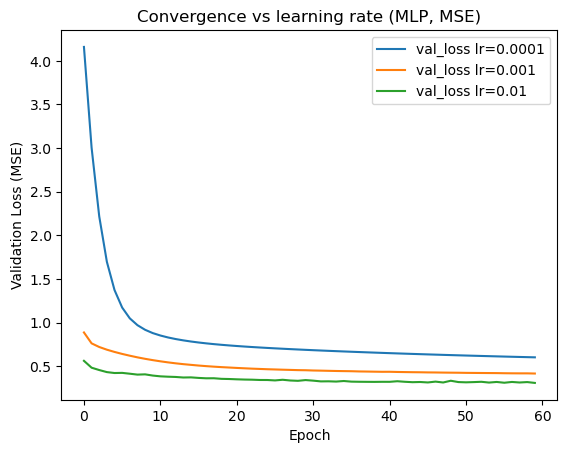

In [10]:
# TODO: Train the same MLP under at least 3 learning rates (e.g., 1e-4, 1e-3, 1e-2)
lrs = [1e-4, 1e-3, 1e-2]
histories = {}

for lr in lrs:
    model_lr, hist_lr = compile_and_fit(
        mlp,
        loss_name="mse",
        lr=lr,
        epochs=60
    )
    histories[lr] = hist_lr

plt.figure()
for lr in lrs:
    plt.plot(histories[lr].history["val_loss"], label=f"val_loss lr={lr:g}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss (MSE)")
plt.legend()
plt.title("Convergence vs learning rate (MLP, MSE)")
plt.show()

## Q7. Backpropagation evidence: layer-wise gradient norms

### 🔹 Gradient Norm Diagnostics (Vanishing / Exploding Gradients)

In this step, you will **measure gradient norms** to diagnose whether a network may suffer from **vanishing** or **exploding** gradients.

#### What you need to do:
1. **Compute gradient norms for a single mini-batch**
   - Use a `GradientTape` to compute gradients of the loss w.r.t. the model’s trainable variables
   - Compute the **L2 norm** of each gradient tensor (one per weight/bias variable)

2. **Verify the diagnostic output**
   - Print the batch loss value
   - Print the number of trainable variables
   - Print the first few gradient norms
   - Sanity-check that gradients are **not all `0`**, **not `NaN`**, and **not extremely large**

3. **Interpret what the norms mean (conceptually)**
   - **Very small norms** (close to 0 across layers) can indicate **vanishing gradients**
   - **Very large norms** (spiking to huge values) can indicate **exploding gradients**
   - Healthy training often shows **moderate, non-zero** norms that vary by layer

4. **TODO Extension (Required) — Track gradient norms across epochs**
   - During training, **record gradient norms repeatedly** (e.g., every epoch, or every N batches)
   - Store them in a structured format (e.g., list/dict keyed by epoch and layer/variable)
   - Create a plot (or table) showing how gradient norms change over time
   - Use this evidence to answer **Q4** (analysis of gradient flow problems)

📌 **Why this matters**:  
Gradient norms provide direct evidence of gradient flow quality. Tracking them over training helps you connect theory (vanishing/exploding gradients) to observed optimization behavior.

When completed, you should be able to answer:
- Do gradients shrink as they propagate to earlier layers?
- Do gradients spike or become unstable?
- How does this relate to learning rate, initialization, or activation choice?


In [11]:
# Utility to compute gradient norms per layer for one batch
@tf.function
def batch_grad_norms(model, x_batch, y_batch, loss_fn):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch, training=True)
        loss = loss_fn(y_batch, y_pred)
    grads = tape.gradient(loss, model.trainable_variables)
    norms = [tf.norm(g) for g in grads if g is not None]
    return loss, norms


# Prepare a small batch
x_b = tf.convert_to_tensor(X_train_s[:512], dtype=tf.float32)
y_b = tf.convert_to_tensor(y_train_f[:512], dtype=tf.float32)


# Use a freshly compiled model (MSE)
probe_model = keras.models.clone_model(mlp)
probe_model.build((None, X_train_s.shape[1]))
loss_fn = keras.losses.MeanSquaredError()


# Initialize weights by running one forward pass
_ = probe_model(x_b)


loss_val, norms = batch_grad_norms(probe_model, x_b, y_b, loss_fn)

print("Batch loss:", float(loss_val))
print("Num trainable vars:", len(probe_model.trainable_variables))
print("First 10 grad norms:", [float(n) for n in norms[:10]])


Batch loss: 4.94230842590332
Num trainable vars: 6
First 10 grad norms: [2.2118144035339355, 1.8783302307128906, 4.025362014770508, 2.980426549911499, 3.048034191131592, 3.7882542610168457]


## Q8. Depth study: 1 vs 3 vs 5 hidden layers

### 🔹 Depth vs Performance (Optimization Effects in Deep Networks)

In this step, you will investigate how **network depth** affects training dynamics and generalization.

#### What you need to do:
1. **Build multiple MLP models with different depths**
   - Use the provided function to create a “deep MLP” where:
     - `depth` controls the number of hidden layers
     - `width` controls the number of units per hidden layer
   - Train **at least three depths** (e.g., `1`, `3`, `5`) while keeping everything else constant

2. **Train each model under the same conditions (fair comparison)**
   - Same optimizer (SGD), same loss (`mse`), same learning rate, same epochs, same batch size
   - Change **only depth** so you can isolate its effect

3. **Compare validation loss curves**
   - Plot validation loss vs. epoch for each depth on one graph
   - Observe:
     - Which depth converges fastest?
     - Which depth shows instability (noisy or diverging validation loss)?
     - Which depth appears to overfit or underfit?

4. **TODO (Required): Evaluate final test performance for each depth**
   - After training each model, compute test metrics (at minimum):
     - **RMSE**
     - **MAE**
   - Record results in a small table (depth → RMSE/MAE)

5. **Discuss optimization effects**
   In your written analysis, address:
   - Why deeper networks may train more slowly or become unstable
   - Whether you observe signs of vanishing/exploding gradients as depth increases
   - Whether deeper networks actually generalize better on the test set, or just overfit
   - One improvement you would try (e.g., better initialization, batch norm, residual connections, different learning rate)

📌 **Why this matters**:  
Increasing depth increases model capacity, but it can also make optimization harder. This experiment helps you connect depth to training stability and generalization.

When completed, you should be able to justify:
- Which depth is best for this dataset
- Whether deeper is truly better here, based on **test metrics**, not just training loss


depth =  1 , Time Training: 11.064147880999371
depth =  3 , Time Training: 15.10981111000001
depth =  5 , Time Training: 19.093660065999757


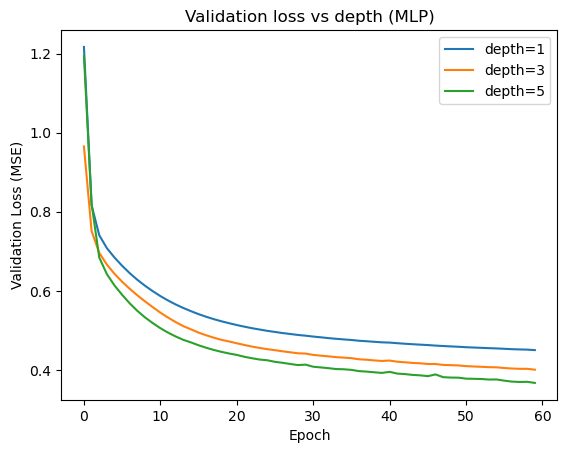

In [19]:
def build_deep_mlp(input_dim: int, depth: int, width: int = 128, activation="relu") -> keras.Model:
    layers_list = [layers.Input(shape=(input_dim,))]
    for _ in range(depth):
        layers_list.append(layers.Dense(width, activation=activation))
    layers_list.append(layers.Dense(1))
    return keras.Sequential(layers_list)

depths = [1, 3, 5]
depth_hist = {}

for d in depths:
    start_time = time.perf_counter() #Recording time to see how long each depth takes to train
    model_d = build_deep_mlp(input_dim, depth=d, width=128, activation="relu")
    model_d, hist_d = compile_and_fit(model_d, loss_name="mse", lr=1e-3, epochs=60)
    depth_hist[d] = hist_d
    end_time = time.perf_counter()
    time_elapsed = end_time - start_time #Calculating time elapsed to train each depth
    print("depth = ", d, ", Time Training:", time_elapsed)

plt.figure()
for d in depths:
    plt.plot(depth_hist[d].history["val_loss"], label=f"depth={d}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss (MSE)")
plt.legend()
plt.title("Validation loss vs depth (MLP)")
plt.show()

# TODO: Evaluate final test metrics for each depth and discuss optimization effects.

## Q9. Final evaluation (test set)

### 🔹 Final Model Evaluation

#### What you need to do:
1. **Select your best model** based on validation performance from previous experiments.
2. **Evaluate the selected model** on both the **validation** and **test** sets.
3. **Report key metrics** (loss, RMSE, MAE).
4. **Briefly explain**:
   - Why this model was chosen
   - Whether test performance matches validation performance


In [13]:
def evaluate(model: keras.Model, X, y):
    return dict(zip(model.metrics_names, model.evaluate(X, y, verbose=0)))

# Choose one trained model as your final (TODO: replace with your best model)
final_model = mlp_mse

results_test = evaluate(final_model, X_val_s, y_val_f)
results_val  = evaluate(final_model, X_test_s, y_test_f)

print("Validation:", results_val)
print("Test:", results_test)

Validation: {'loss': 0.37969547510147095, 'rmse': 0.6161943674087524, 'mae': 0.4421570897102356}
Test: {'loss': 0.4100724756717682, 'rmse': 0.6403689980506897, 'mae': 0.45241987705230713}


## Results & Discussion (Answer Each Question Clearly)

- **Review and answer the following questions carefully briefly**


### Q10. Loss Functions (MSE vs MAE)
- Which loss **converged faster**?
- Which achieved **lower validation loss**?
- Why did their behaviors differ (outlier sensitivity, gradient properties)?

**Type your answer here

- Which loss converged faster?

  
    According to the graph in Q5 the MAE seems to converge slower than the MSE. Even though the MSE starts at a high loss, it descends rapidly, while the MAE descends a little slower. Therefore, from the results in Q5, the MSE descends and converges quicker than MAE.

- Which achieved lower validation loss?

  
    The MSE had lower validation loss after outputting the minimum validation loss. The print statement refrenced when typing this is below.

  MSE Lowest Val Loss: 0.41292813420295715

  
  MAE Lowest Val Loss: 0.4682556092739105

- Why did their behaviors differ (outlier sensitivity, gradient properties)?

  
    The behaviors of the MSE and MAE loss functions differ because of how the functions weight values. MAE or Mean Absolute Error, takes the absolute value of the error between the true versus predicted value. This in turn evenly weights every error value. MSE or Mean Square Error, squares the error betwee the true versus predicted value. This then weights the higher errors more since a higher error leads to a exponentially greater loss. Therefore, this makes sense that the MSE loss function converges and descends faster as it leads to greater loss values. In addition, it explains why the MSE loss started at a higher loss. For outlier sensitivity, the MSE loss function would be more sensitive to outliers due to being sensitive to large values. 

### Q11. Model Capacity (Single-Layer vs Multi-Layer)
- How does the **perceptron** perform compared to the **MLP**?
- What limitations does the single-layer model show (linear decision function, underfitting)?

**Type your answer here:**

- How does the perceptron perform compared to the MLP?

    The MLP outperforms in classification compared to the perceptron. However, the perceptron does use less memory and space. Using about 36 bytes for parameters, while the MLP uses 37 KB. This right now is negligable, but as the amount of paramters increase in a model, this difference could be an issues potentially.

- What limitations does the single-layer model show (linear decision function, underfitting)?

    The single-layer model is limited in that it can only model linear decisions. For example, graphically, if there is data that has a boundary that is curved, a single-layer perceptron could not model that boundary. When a model does not effectively define boundaries and over-generalizes, it is called underfitting. Therefore, the single-layer model if applied to a non-linear data, will underfit the data.

### Q12. Effect of Network Depth
- Compare **1 vs 3 vs 5 hidden layers**:
  - Convergence speed
  - Stability during training
  - Validation/test generalization
- What trade-offs are observed as depth increases?

**Type your answer here:**

- Compare 1 vs 3 vs 5 hidden layers:

    The convergence speed of each different depth decreases the more layers there are. One hidden layer converged the slowest and three hidden layers converged the quickest. For stability, the single hidden layer has a very smooth line for its loss as it dcreases and as more layers are added the line seems a little more speratic. So as the layers increase, the model seems to destabalize. As more hidden layers are added, the generalization seems to improve as the validation loss decreases with more layers. There does not seem to be overfitting as all the validation loss decreases and converges. However, whether or not there is underfitting may not be seen, but each model doesn't seem to underfit this data set. This is most likely due to at least one hiddenlayer being present, complex functions can be represented.

- What trade-offs are observed as depth increases?

    There were a couple trade offs observed due to the analysis above. The more depth, the more features will be extracted and the quicker the model will converge. One downside of more depth observed is that as layers increase sability decreases. Another downside observed was that as layers are added, training time increases. This is intuitively true, but just to check and get numbers, the amount of time to train each depth amount was calculated. One hidden layer took about 11 seconds to train, three hidden layers took 15 seconds, and then five layers took 19 seconds. So as the layers were added, time to train also increased. For this small scale MLP the time difference is noticable, but for the application is negligable. However, if one is to add many more hidden layers to a network, this time difference can become an issue. 

### Q13. Conclusion (Answer Explicitly)

- Which **model configuration** performed best and **why** (cite metrics/figures)?
- What **one limitation** of feedforward networks did you observe (e.g., hyperparameter sensitivity, gradient issues, overfitting)?

**Type your answer here:** \
Based on the different architecture changes done in this lab, our MLP using a MSE loss function would perform the best. Q5 showed how MSE coverges faster than MAE. While this configuration had only two hidden layers, the final loss was comparable to the depth 5 model (~0.4). This is likely due the varaible, decreasing length of the MSE model (128 to 64) versus the constant 128 length of the depth 5 model. In our testing, specifically in Q7, we did experience a little bit of vansishing gradients. The earlier gradients tended to be smaller than the later gradients. Extending this behavior to a significantly larger depth could result in gradients small enough to not traing the other layers.

### 🎉 Congratulations!

You have successfully completed **Assignment 1**. Excellent work engaging with the fundamental concepts of **multi-layer perceptrons** and **backpropagation**.

### **Submission Instructions**

Please submit a **GitHub repository link** on Canvas that contains:
- The **completed Jupyter notebook**
- Any additional files required for the assignment (if applicable)

Before submitting, ensure that:
- All **code cells (Q2–Q9)** have been executed successfully
- All **Markdown responses (Q10–Q13)** have been completed
- The notebook is **saved after execution** so that outputs are visible

Once verified, **push the final version to GitHub** and submit the repository link on Canvas.

